In [1]:
import torch
import pytorch_lightning as pl
import yaml
import sys
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from glob import glob
import torch.nn.functional as F
from pytorch_lightning.loggers import TensorBoardLogger

In [2]:
sys.path.append("/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE")

In [3]:
from scripts.diffusion.schedules import TimestepSampler
from scripts.diffusion.ResUnet_timeembed import Unet, Unet_ref
from scripts.maploader.maploader import get_data, get_normalized_data, get_log2linear_transform, get_loaders
from run.diffusion.run_diffusion import DDPM, mask_with_gaussian
from scripts.utils.diffusion_utils import extract
from scripts.utils.run_utils import setup_trainer

/gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
pl.seed_everything(1234)

[rank: 0] Global seed set to 1234


1234

# Data Loading

In [5]:
target = "difference"
schedule = "linear"
norm = "sigmoid"
version = "7"
base_dir = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE"
ckpt_dir = f"{base_dir}/ckpt_logs/diffusion/{target}/{target}_{schedule}_{norm}_o2_b6_ref/version_{version}"

with open(f"{ckpt_dir}/hparams.yaml", 'r') as stream:
    config_dict = yaml.safe_load(stream)

In [6]:
config_dict["data"]["transform_type"] = "both"
config_dict["train"]['batch_size'] = 2
config_dict["data"]["n_maps"] = 3
config_dict["train"]['log_name'] = f"{config_dict['train']['target']}_{config_dict['diffusion']['schedule']}_{config_dict['data']['transform_type']}_o{config_dict['data']['order']}_b{config_dict['train']['batch_size']}"
config_dict['train']['patience'] = 30



In [7]:
parms = config_dict

lr = get_data(parms["data"]["LR_dir"], parms["data"]["n_maps"], parms["data"]["nside"], parms["data"]["order"], issplit=True)   
print("LR data loaded from {}.  Number of maps: {}".format(parms["data"]["LR_dir"], parms["data"]["n_maps"]))

hr = get_data(parms["data"]["HR_dir"], parms["data"]["n_maps"], parms["data"]["nside"], parms["data"]["order"], issplit=True)
print("HR data loaded from {}.  Number of maps: {}".format(parms["data"]["HR_dir"], parms["data"]["n_maps"]))

LR data loaded from /gpfs02/work/akira.tokiwa/gpgpu/FastPM/healpix/nc128/.  Number of maps: 3
HR data loaded from /gpfs02/work/akira.tokiwa/gpgpu/FastPM/healpix/nc256/.  Number of maps: 3


In [8]:
lr, transform_lr, inverse_transform_lr, range_min_lr, range_max_lr = get_normalized_data(lr, transform_type=parms["data"]["transform_type"])
print("LR data normalized to [{},{}] by {} transform.".format(lr.min(), lr.max(), parms["data"]["transform_type"]))

if target == 'difference':
    log2linear_transform, inverse_log2linear_transform = get_log2linear_transform()
    diff = log2linear_transform(hr) - log2linear_transform(inverse_transform_lr(lr))*(parms["data"]["upsample_scale"]**3)
    print("Difference data calculated from HR - LR*upsample_scale^3. min: {}, max: {}".format(diff.min(), diff.max()))
    diff, transforms_diff, inverse_transforms_diff, range_min_diff, range_max_diff = get_normalized_data(diff, transform_type=parms["data"]["transform_type"])
    print("Difference data normalized to [{},{}] by {} transform.".format(diff.min(), diff.max(), parms["data"]["transform_type"]))
    data_input, data_condition = diff, lr
elif target == 'HR':
    hr, transforms_hr, inverse_transforms_hr, range_min_hr, range_max_hr = get_normalized_data(hr, transform_type=parms["data"]["transform_type"])
    print("HR data normalized to [{},{}] by {} transform.".format(hr.min(), hr.max(), parms["data"]["transform_type"]))
    data_input, data_condition = hr, lr
else:
    raise ValueError("target must be 'difference' or 'HR'")

print("data nside: {}, divided into {} patches, each patch has {} pixels.".format(parms["data"]["nside"], 12 * parms["data"]["order"]**2, hp.nside2npix(parms["data"]["nside"])//(12 * parms["data"]["order"]**2)))

LR data normalized to [-1.0,1.0] by both transform.
Difference data calculated from HR - LR*upsample_scale^3. min: -295.9996032714844, max: 176.0
Difference data normalized to [-1.0,1.0] by both transform.
data nside: 512, divided into 48 patches, each patch has 65536 pixels.


In [9]:
sample_map = np.hstack(data_input[:48, :, 0].detach().cpu().numpy())

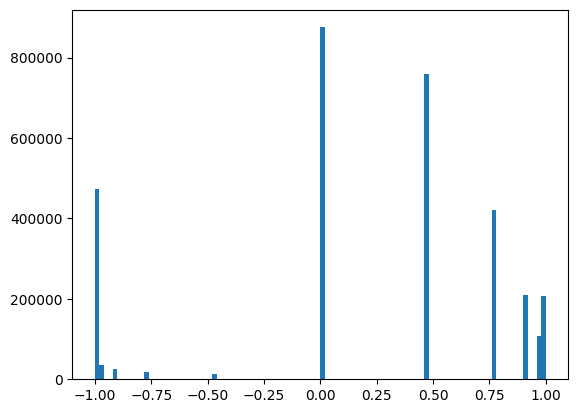

In [10]:
plt.hist(sample_map, bins=100)
plt.show()

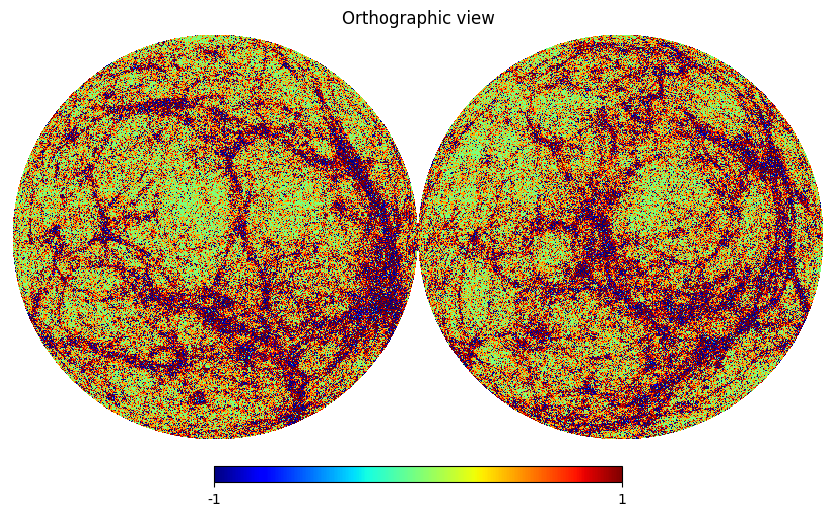

In [11]:
hp.orthview(sample_map, nest=True, cmap="jet")

In [12]:
# set up model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#get sampler type
timesteps = int(config_dict['diffusion']['timesteps'])
sampler = TimestepSampler(timesteps=timesteps, sampler_type=config_dict['diffusion']['sampler_type'])

Sampler type uniform


In [13]:
#get model
model = DDPM(Unet_ref, config_dict, sampler = sampler).to(device)

We are using Adam with lr = 0.0001, gamma = 0.9999
The schedule is linear with beta_start = 1e-06, beta_end = 0.01


In [14]:
train_loader, val_loader = get_loaders(data_input, data_condition, parms["train"]['train_rate'], parms["train"]['batch_size'])
print("train:validation = {}:{}, batch_size: {}".format(len(train_loader), len(val_loader), parms["train"]['batch_size']))

train:validation = 58:15, batch_size: 2


In [15]:
logger = TensorBoardLogger(save_dir=parms["train"]['save_dir'], name=parms["train"]['log_name'])
print("data saved in {}".format(parms["train"]['save_dir']))
print("data name: {}".format(parms["train"]['log_name']))

data saved in /gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/ckpt_logs/diffusion/difference/
data name: difference_linear_both_o2_b2


In [16]:
trainer = setup_trainer(logger=logger, fname=None, save_top_k=int(parms['train']['save_top_k']), max_epochs=int(parms['train']['n_epochs']), patience=int(parms['train']['patience']))

/gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

/gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name  | Type     | Params
-----------------------------------
0 | model | Unet_ref | 35.8 M
-----------------------------------
35.8 M    Trainable params
0         Non-trainable params
35.8 M    Total params
143.147   Total estimated model params size (MB)


Epoch 0:  78%|███████▊  | 57/73 [01:52<00:31,  1.98s/it, loss=5.56, v_num=1]    

/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/scripts/diffusion/diffusionclass.py:52: UserWarning: Using a target size (torch.Size([2, 65536, 1])) that is different to the input size (torch.Size([1, 65536, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(noise, predicted_noise)


Epoch 0:  79%|███████▉  | 58/73 [01:54<00:29,  1.98s/it, loss=5.19, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 1:  42%|████▏     | 31/73 [01:03<01:25,  2.03s/it, loss=4.66, v_num=1]

In [36]:
ckpt_path = sorted(glob(f"{ckpt_dir}/checkpoints/*.ckpt"), key=lambda x: float(x.split('=')[-1].rsplit('.', 1)[0]))[-1]
model.load_state_dict(ckpt["state_dict"], strict=False)
model.eval()
model.freeze()
print("Model loaded")

#get diffusion
tmp_diffusion = model.diffusion

Model loaded


In [46]:
sample = np.load("/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/results/imgs/diffusion/HR/HR_linear_sigmoid_o2_b6/version_0/diffused_step_900_patch_00.npy")

In [47]:
samples = np.hstack([sample for i in range(4)])

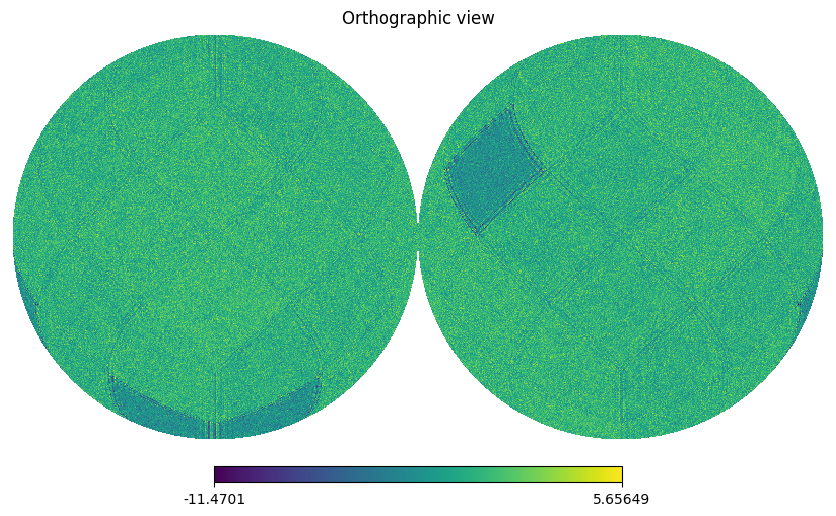

In [48]:
hp.orthview(samples, nest=True)

In [7]:
lr_sample = np.hstack(lr[:PATCH_SIZE, :, 0].detach().cpu().numpy()) 
hr_sample = np.hstack(hr[:PATCH_SIZE, :, 0].detach().cpu().numpy())
noisy_hr_sample = hr_sample + np.random.normal(0, 0.4, hr_sample.shape)
diff_sample = hr_sample - lr_sample
noisy_diff_sample = diff_sample + np.random.normal(0, 0.4, diff_sample.shape)
noise_sample = np.random.normal(0, 0.4, hr_sample.shape)

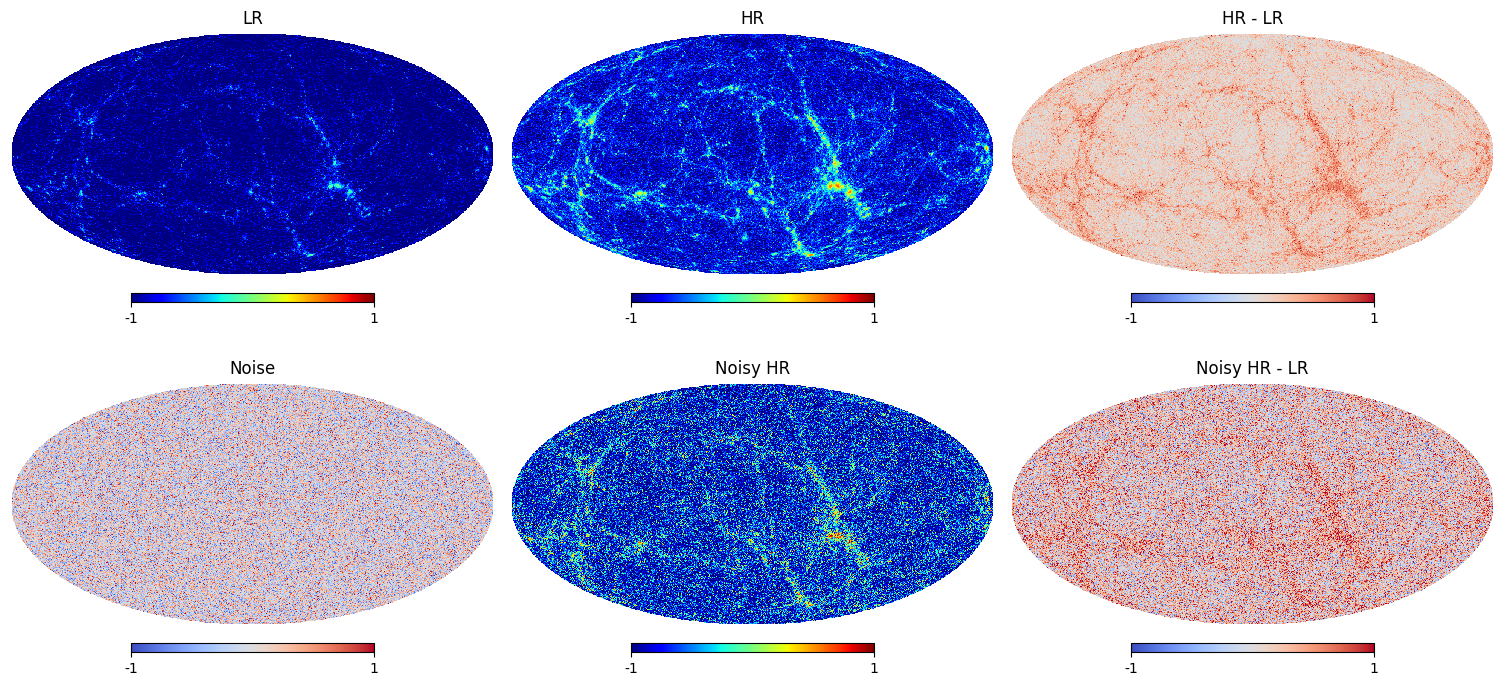

In [8]:
fig = plt.figure(figsize=(15, 7))
hp.mollview(lr_sample, fig=fig, nest=True, title="LR", sub=(2, 3, 1), min=-1, max=1, cmap='jet')
hp.mollview(hr_sample, fig=fig, nest=True, title="HR", sub=(2, 3, 2), min=-1, max=1, cmap='jet')
hp.mollview(diff_sample, fig=fig, nest=True, title="HR - LR", sub=(2, 3, 3), min=-1, max=1, cmap='coolwarm')
hp.mollview(noisy_hr_sample, fig=fig, nest=True, title="Noisy HR", sub=(2, 3, 5), min=-1, max=1, cmap='jet')
hp.mollview(noisy_diff_sample, fig=fig, nest=True, title="Noisy HR - LR", sub=(2, 3, 6), min=-1, max=1, cmap='coolwarm')
hp.mollview(noise_sample, fig=fig, nest=True, title="Noise", sub=(2, 3, 4), min=-1, max=1, cmap='coolwarm')
plt.show()

In [13]:
print("Start Diffusion")
test_batch =2
tmp_sample = mask_with_gaussian(data_input[:test_batch].to(device), device)
tmp_lr = data_condition[:test_batch].to(device)
img = torch.randn(tmp_sample.shape, device=device)
imgs = []
with torch.no_grad():
    for j in reversed(range(990, timesteps)):
        t = torch.full((test_batch,), j, device=device, dtype=torch.long)
        img = tmp_diffusion.p_sample(model.model, img, t, t_index=j, condition=tmp_lr)
        imgs.append(img.detach().cpu().numpy())
        loss = tmp_diffusion.p_losses(model.model, tmp_sample, t, condition=tmp_lr, loss_type=config_dict['diffusion']['loss_type'])
        print('Current step {}, Loss {}'.format(j, loss), flush=True)
        if img.min() < -1e3 or img.max() > 1e3:
            print("Diverged at step {}, aborting.".format(j))
            break

Start Diffusion
Current step 999, Loss 0.013460907153785229
Current step 998, Loss 0.013305693864822388
Current step 997, Loss 0.013093703426420689
Current step 996, Loss 0.012864690274000168
Current step 995, Loss 0.012811772525310516
Current step 994, Loss 0.01295221783220768
Current step 993, Loss 0.013300031423568726
Current step 992, Loss 0.014252984896302223
Current step 991, Loss 0.01563950628042221
Current step 990, Loss 0.01719544641673565


In [29]:
tmp_sample =data_input[:test_batch].to(device)
tmp_lr = data_condition[:test_batch].to(device)
img = torch.randn(tmp_sample.shape, device=device)
with torch.no_grad():
    for j in reversed(range(990, timesteps)):
        t = torch.full((test_batch,), j, device=device, dtype=torch.long)
        betas_t = extract(tmp_diffusion.betas, t, img.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(
            tmp_diffusion.sqrt_one_minus_alphas_cumprod, t, img.shape
        )
        sqrt_recip_alphas_t = extract(tmp_diffusion.sqrt_recip_alphas, t, img.shape)
        model_output = model.model(img, t, condition=tmp_lr)
        model_mean = sqrt_recip_alphas_t * (
                img - betas_t * model_output / sqrt_one_minus_alphas_cumprod_t
        )
        posterior_variance_t = extract(tmp_diffusion.posterior_variance, t, img.shape)
        noise = torch.randn_like(img)
        x_t = tmp_diffusion.q_sample(x_start=tmp_sample, t=t, noise=torch.randn_like(tmp_sample))
        predicted_noise = model.model(x_t, t, condition=tmp_lr)
        loss = F.smooth_l1_loss(noise, predicted_noise)
        print("step {}: current loss {}".format(j, loss))
        img = model_mean + torch.sqrt(posterior_variance_t) * noise

step 999: current loss 0.7202585935592651
step 998: current loss 0.7226333618164062
step 997: current loss 0.7264481782913208
step 996: current loss 0.7267915606498718
step 995: current loss 0.7264732122421265
step 994: current loss 0.727920413017273
step 993: current loss 0.7260657548904419
step 992: current loss 0.7269684672355652
step 991: current loss 0.7273987531661987
step 990: current loss 0.7295007109642029


# Visualization

In [5]:
def read_maps(map_dir, diffsteps=100, batch_size=4):
    maps = sorted(glob(map_dir + "/*.npy"), key=lambda x: (int(x.split("/")[-1].split("_")[2]), int(x.split("/")[-1].split(".")[0].split("_")[-1])))
    map_diffused = []
    for i in range(diffsteps):
        map_steps = []
        for j in range(batch_size):
            #print("Current map: {}".format(maps[i*batch_size+j]))
            map_steps.append(np.load(maps[i*batch_size+j]))
        map_steps = np.array(map_steps)
        map_steps = np.hstack(map_steps)
        map_diffused.append(map_steps)
    map_diffused = np.array(map_diffused)
    return map_diffused

In [11]:
NUM_BATCHES = int(12 * (config_dict['data']['order'])**2 / (config_dict['train']['batch_size']*2))
timesteps = int(config_dict['diffusion']['timesteps'])
map_dir = f"{base_dir}/results/imgs/diffusion/{target}/{config_dict['train']['log_name']}/version_{version}"
map_diffused = read_maps(map_dir, diffsteps=timesteps//10, batch_size=NUM_BATCHES)
print(f"map_diffused.shape: {map_diffused.shape}")

map_diffused.shape: (100, 3145728)


In [12]:
map_dir

'/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/results/imgs/diffusion/difference/difference_linear_o2_b6/version_2'

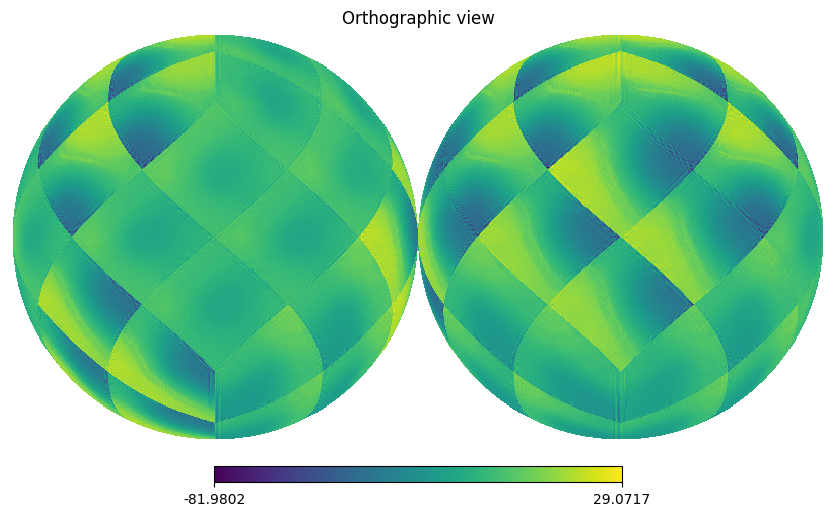

In [16]:
hp.orthview(map_diffused[0], nest=True)

In [19]:
map_diffused = read_maps(map_dir, diffsteps=100, batch_size=16)

In [23]:
lr = get_data(lrmaps_dir, n_maps, nside, order, issplit=False)
hr = get_data(hrmaps_dir, n_maps, nside, order, issplit=False)

hr, transforms_hr, inverse_transforms_hr, range_min_hr, range_max_hr = get_minmaxnormalized_data(hr)
print("HR data loaded. min: {}, max: {}".format(range_min_hr, range_max_hr))

lr = transforms_hr(lr)
print("LR data normalized by HR range. min: {}, max: {}".format(lr.min(), lr.max()))

HR data loaded. min: 0.0, max: 2.903632402420044
LR data normalized by HR range. min: -1.0, max: 0.38642704486846924


In [86]:
lr_hp = inverse_transforms_hr(lr).detach().cpu().numpy()[0, : , 0]
lr_sample = lr.detach().cpu().numpy()[0, : , 0]
hr_hp = inverse_transforms_hr(hr).detach().cpu().numpy()[0, : , 0]

In [61]:
def t2hpr(x):
    x_hp = hp.pixelfunc.reorder(x, n2r=True)
    return x_hp

def inverse_transforms_hp(x, range_min, range_max):
    x = (x + 1) / 2 * (range_max - range_min) + range_min
    return x

In [167]:
def plot_ps(cls, fig, ax):
    if len(cls) == 2:
        labels = ["input", "target"]
    elif len(cls) == 3:
        labels = ["input", "target", "output"]
    elif len(cls) == 4:
        labels = ["input", "target", "output", "diff"]
    else:
        raise ValueError("cls must be 2 or 3 or 4 length")
    ell = np.arange(len(cls[0]))
    for cl, label in zip(cls, labels):
        ax.plot(ell*(ell+1)*cl/(2*np.pi), label=label, alpha=0.7)
    ax.set_xlabel("l", fontsize=12)
    ax.set_ylabel(r"$l(l+1)C_{l}/2\pi\;\; $", fontsize=12)
    ax.set_yscale("log")
    ax.legend(loc="lower right", fontsize=12)
    return fig, ax

In [168]:
def plot_maps_png(i, sr_hp, lr_hp, hr_hp, png_dir, tmp_min, tmp_max, verbose=False):
    fig = plt.figure(figsize=(12,4))
    hp.mollview(sr_hp, nest=True, fig=fig, title=f'Generated Diff step_{str((99-i)*10).zfill(3)}+ LR', sub=(1,3,1), min=tmp_min, max=tmp_max)
    hp.mollview(hr_hp, nest=True, fig=fig, title='HR', sub=(1,3,2), min=tmp_min, max=tmp_max)
    hp.mollview(lr_hp, nest=True, fig=fig, title='LR', sub=(1,3,3), min=tmp_min, max=tmp_max)
    if verbose:
        plt.show()
    else:
        fig.savefig(png_dir + f"/step_{(99-i)*10}.png", dpi=200, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)

def plot_ps_png(i, cls, ps_dir, lmax, verbose=False):
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    fig, ax = plot_ps(cls, fig, ax)
    ax.set_title(f"step_{str((99-i)*10).zfill(3)}")
    if verbose:
        plt.show()
    else:
        fig.savefig(ps_dir + f"/step_{(99-i)*10}_ps.png", dpi=200, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)

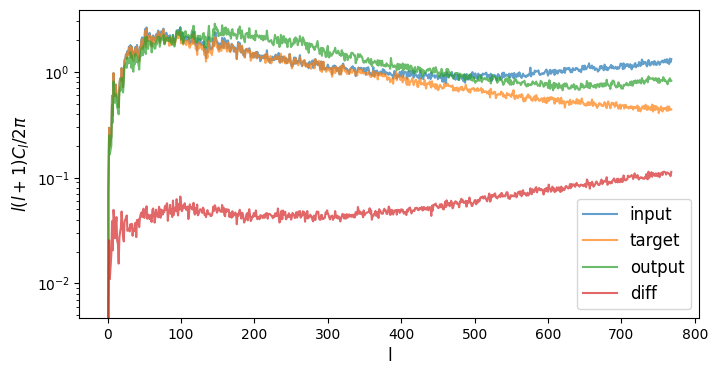

In [169]:
output_cl =hp.sphtfunc.anafast(np.exp(np.log(10)*t2hpr(sr_hp)-1), lmax=lmax)
diff_cl = hp.sphtfunc.anafast(np.exp(np.log(10)*t2hpr(sr_hp - lr_hp)-1), lmax=lmax)
cls = [input_cl, target_cl, output_cl, diff_cl]

fig, ax = plt.subplots(1,1, figsize=(8,4))
fig, ax = plot_ps(cls, fig, ax)

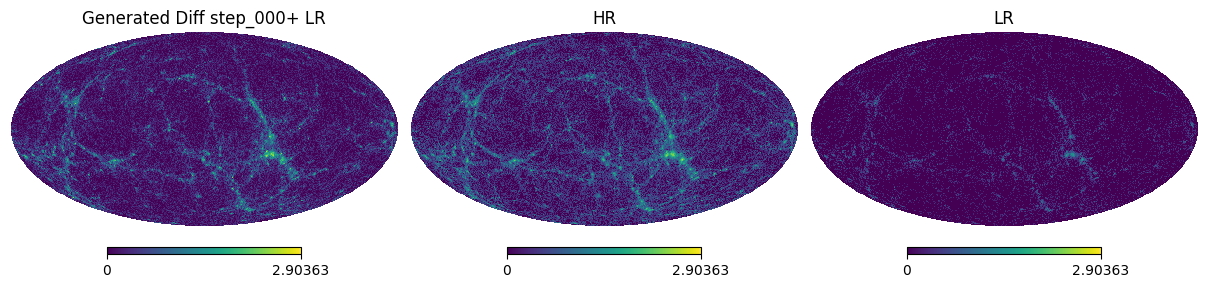

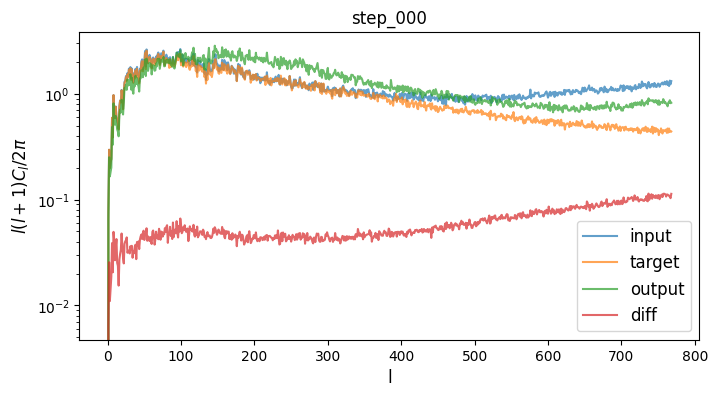

In [170]:
plot_maps_png(99, sr_hp, lr_hp, hr_hp, map_dir + "/png", range_min_hr, range_max_hr, True)
plot_ps_png(99, cls, map_dir + "/ps", 3*nside, True)